In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 1
LR = 5e-1
EPOCH = 100
criterion = nn.CrossEntropyLoss()

In [3]:
num_classes_ko = 3
num_classes_en = 6
input_size_ko = 3
output_size_ko = 3
input_size_en = 6
output_size_en = 6

hidden_size = 3

idx2word_ko = ['저는', '강사', '입니다']
idx2word_en = ['<sos>','I','am','an','instructor','<eos>'] # 6개 클래스
x_data_ko = [0,1,2]
x_data_en = [0,1,2,3,4] # 입력은 <sos>','I','am','an','instructor'
one_hot_lookup_ko = torch.eye(3).tolist()
one_hot_lookup_en = torch.eye(6).tolist()
y_data = [1,2,3,4,5] # 출력은 'I','am','an','instructor','<eos>'
seq_len_ko = 3
seq_len_en = 5

x_one_hot_ko = [one_hot_lookup_ko[x] for x in x_data_ko]
x_one_hot_en = [one_hot_lookup_en[x] for x in x_data_en]
X_ko = torch.tensor(x_one_hot_ko).unsqueeze(dim=0) # X.shape = (Data_size, seq_len, input_size)
X_en = torch.tensor(x_one_hot_en).unsqueeze(dim=0)
Y = torch.tensor(y_data).reshape(1,-1,1) # Y.shape = (Data_size, seq_len, 1)
print(X_ko)
print(X_en)
print(Y)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])
tensor([[[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.]]])
tensor([[[1],
         [2],
         [3],
         [4],
         [5]]])


In [4]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, X_src, X_trg, Y):
        self.X_src = X_src
        self.X_trg = X_trg
        self.Y = Y

    def __len__(self):
        return self.X_src.shape[0]

    def __getitem__(self, idx):
        x_src = self.X_src[idx]
        x_trg = self.X_trg[idx]
        y = self.Y[idx]
        return (x_src, x_trg), y

custom_DS = Custom_Dataset(X_ko, X_en, Y)
train_DL = torch.utils.data.DataLoader(custom_DS, batch_size = BATCH_SIZE, shuffle = False)

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first=True)

    def forward(self, x, h_init, c_init):
		# out, (h, c) = self.lstm(x, (h_init, c_init)) # x.shape = (BS,seq_len,input_size)
		# out.shape = (BS,seq_len,hidden_size), h.shape = (D*num_layer, BS, hidden_size) == c.shape
        # out.shape 은 개단채, h.shape은 레개채

		# rnn cell 한번씩 통과시켜서 각 hi 를 저장하자
        self.h = []
        out=torch.tensor([])
        hi = h_init
        ci = c_init
        seq_len = x.shape[1]
        for j in range(seq_len):
            x_letter = x[:,j,:].unsqueeze(dim=1) # x.shape = (BS,seq_len,input_size) 를 맞춰줌
            _, (hi, ci) = self.lstm(x_letter, (hi, ci)) # y_hat.shape = (BS,seq_len,hidden_size)
            hi.retain_grad()
            self.h += [hi]
            out = torch.cat([out, hi.permute(1,0,2)], dim=1) # out.shape = (BS,seq_len,hidden_size)
            # .permite(1,0,2) 는 사실 D*num_layer=1 이라서 가능한거지 엄밀하게는 틀림 (개레채로 출력)
        return out, (hi.permute(1,0,2), ci.permute(1,0,2))

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cells = LSTM(input_size = input_size, hidden_size = hidden_size)

    def forward(self, src, h_init, c_init):
        _, (h, _) = self.cells(src, h_init, c_init)
        return h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.cells = LSTM(input_size = input_size, hidden_size = hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, trg, h_init, c_init):
        out, (h,c) = self.cells(trg, h_init, c_init)
        dec_out = self.fc(out)
        return dec_out, (h,c)

class seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def forward(self, src, trg):
        # src : 변역하고 싶은 문장
        h_init = torch.zeros(1, src.shape[0], hidden_size) # h.shape = (D*num_layer, BS, hidden_size) 를 맞춰줌
        c_init = torch.zeros(1, src.shape[0], hidden_size) # 어차피 src.shape[0] == trg.shape[0]
        h_enc = self.enc(src, h_init, c_init) # encoder h
        dec_out, _ = self.dec(trg, h_enc, c_init) # decoder에 넣어줌
        return dec_out

In [6]:
model = LSTM(input_size_ko, hidden_size) # 테스트
print(model)
(src_batch, _), _ = next(iter(train_DL))
# x.shape = (BS,seq_len,input_size) 를 맞춰줌
h_init = torch.zeros(1, src_batch.shape[0], hidden_size) # h.shape = (D*num_layer, BS, hidden_size) == c.shape 를 맞춰줌
c_init = torch.zeros(1, src_batch.shape[0], hidden_size)
y_hat, (h_hat, c_hat) = model(src_batch, h_init, c_init) # 0 번째 글자
# y_hat.shape = (BS,seq_len,hidden_size)
print(src_batch.shape)
print(y_hat.shape)
print(h_hat.shape)
print(c_hat.shape)

LSTM(
  (lstm): LSTM(3, 3, batch_first=True)
)
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 1, 3])
torch.Size([1, 1, 3])


In [7]:
encoder = Encoder(input_size_ko, hidden_size)
decoder = Decoder(input_size_en, hidden_size, output_size_en)
model = seq2seq(encoder, decoder)
print(model)
(x_src, x_trg), _ = next(iter(train_DL))
y_hat = model(x_src, x_trg)
print(x_src.shape)
print(x_trg.shape)
print(y_hat.shape)

seq2seq(
  (enc): Encoder(
    (cells): LSTM(
      (lstm): LSTM(3, 3, batch_first=True)
    )
  )
  (dec): Decoder(
    (cells): LSTM(
      (lstm): LSTM(6, 3, batch_first=True)
    )
    (fc): Linear(in_features=3, out_features=6, bias=True)
  )
)
torch.Size([1, 3, 3])
torch.Size([1, 5, 6])
torch.Size([1, 5, 6])


In [8]:
def Train(model, train_DL, criterion, **kwargs):
    optimizer=optim.SGD(model.parameters(), lr = kwargs["LR"])

    NoT=len(train_DL.dataset) # Number of training data
    loss_history = []
    mean_grad_history_enc=torch.tensor([])
    mean_grad_history_dec=torch.tensor([])

    model.train() # train mode로!
    for ep in range(kwargs["EPOCH"]):
        rloss = 0
        rgrad_enc = torch.zeros(seq_len_ko)
        rgrad_dec = torch.zeros(seq_len_en)
        print("predicted string: ", end='')
        for (x_src, x_trg), y_batch in train_DL:
            # x_src.shape = (BS, seq_len, input_size)
            # y_batch.shape = (BS, seq_len, 1)
            # grad (batch)
            y_hat = model(x_src, x_trg) # y_hat.shape = (BS,seq_len,hidden_size)
            L4 = criterion(y_hat[0,-2,:].reshape(1,-1), y_batch[0,-2,:].reshape(-1)) # y_batch는 1D 여야 함
            # 0 번째 data에 대해서만 L4 계산 (멀수록 잊혀지는 현상만 보기 위해)
            # L4 는 instructor가 나오게 하기 위한 loss
            L4.backward()
            rgrad_enc += torch.tensor([model.enc.cells.h[i].grad.abs().sum() * x_src.shape[0] for i in range(seq_len_ko)])
            rgrad_dec += torch.tensor([model.dec.cells.h[i].grad.abs().sum() * x_src.shape[0] for i in range(seq_len_en)])
            # inference
            y_hat = model(x_src, x_trg)
            # cross entropy loss
            loss = 0
            for i in range(x_src.shape[0]):
                loss += criterion(y_hat[i], y_batch[i].reshape(-1)) # y_batch는 1D 여야 함
                pred = y_hat[i].argmax(dim=1)
                print(*[idx2word_en[p] for p in pred])
            # update
            optimizer.zero_grad() # gradient 누적을 막기 위함
            loss.backward() # backpropagation
            optimizer.step() # weight update
            # loss accumulation
            loss_b = loss.item() * x_src.shape[0] # batch loss # BATCH_SIZE 로 하면 마지막 16개도 32개로 계산해버림
            rloss += loss_b # running loss
        # grad and weight (epoch)
        mean_grad_history_enc = torch.cat([mean_grad_history_enc, rgrad_enc.reshape(1,-1)/NoT], dim=0)
        mean_grad_history_dec = torch.cat([mean_grad_history_dec, rgrad_dec.reshape(1,-1)/NoT], dim=0)
        # print loss
        loss_e = rloss/NoT # epoch loss
        loss_history += [loss_e]
        print("Epoch:", ep+1, "train loss:", round(loss_e,5) )
        print("-"*20)
    return loss_history, mean_grad_history_enc, mean_grad_history_dec

In [9]:
encoder = Encoder(input_size_ko, hidden_size)
decoder = Decoder(input_size_en, hidden_size, output_size_en)
model = seq2seq(encoder, decoder)
loss_history, mean_grad_history_enc, mean_grad_history_dec = Train(model, train_DL, criterion,
                                                                   LR=LR, EPOCH=EPOCH)

predicted string: am am am am am
Epoch: 1 train loss: 1.83204
--------------------
predicted string: am am am am am
Epoch: 2 train loss: 1.80292
--------------------
predicted string: am am am am am
Epoch: 3 train loss: 1.77853
--------------------
predicted string: am am am am am
Epoch: 4 train loss: 1.75787
--------------------
predicted string: am am am am am
Epoch: 5 train loss: 1.74015
--------------------
predicted string: am am am am am
Epoch: 6 train loss: 1.72475
--------------------
predicted string: am am am am am
Epoch: 7 train loss: 1.71116
--------------------
predicted string: am am am am an
Epoch: 8 train loss: 1.69899
--------------------
predicted string: am am am am an
Epoch: 9 train loss: 1.68793
--------------------
predicted string: am am am am an
Epoch: 10 train loss: 1.67773
--------------------
predicted string: am am an am an
Epoch: 11 train loss: 1.66817
--------------------
predicted string: am am an am an
Epoch: 12 train loss: 1.65909
--------------------
p

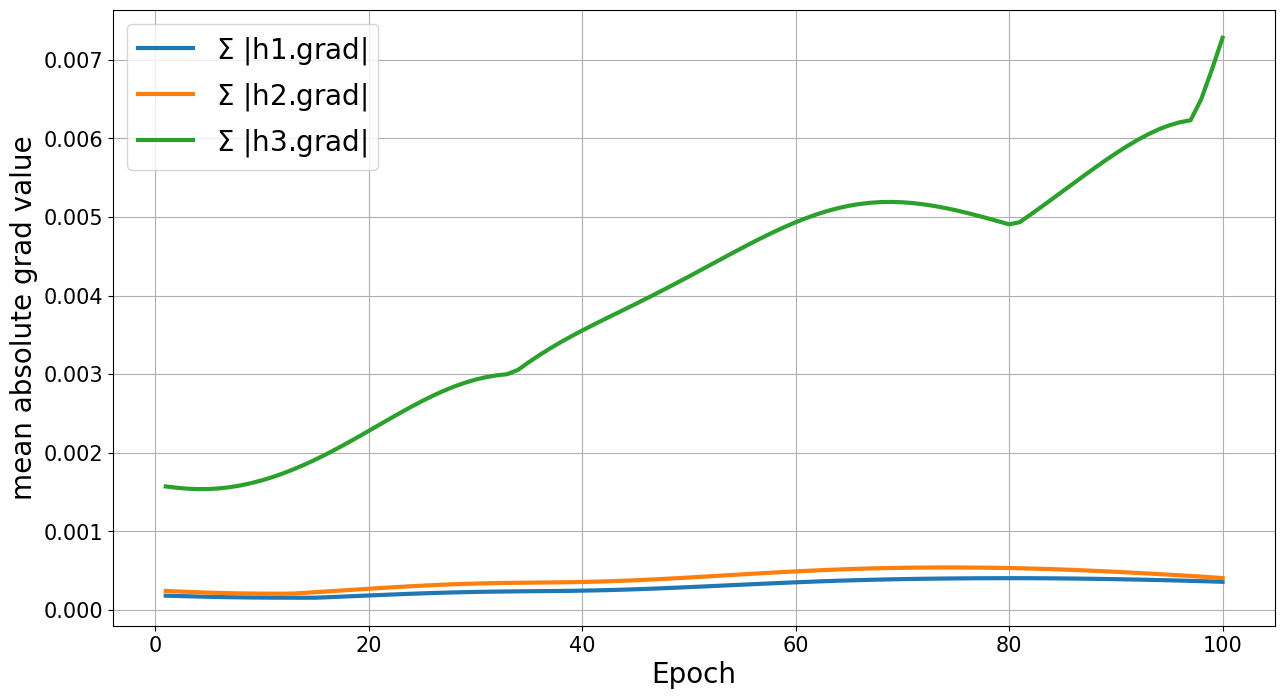

In [11]:
plt.figure(figsize=[15,8])
plt.plot(range(1,EPOCH+1), mean_grad_history_enc[:,0], label = "$\Sigma$ |h1.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history_enc[:,1], label = "$\Sigma$ |h2.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history_enc[:,2], label = "$\Sigma$ |h3.grad|", linewidth=3)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("mean absolute grad value", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

Loss가 h3를 가장 많이 보는 것 확인, 다른 인코더 h gradient는 거의 없어진다
- 입니다 를 제일 많이 본다

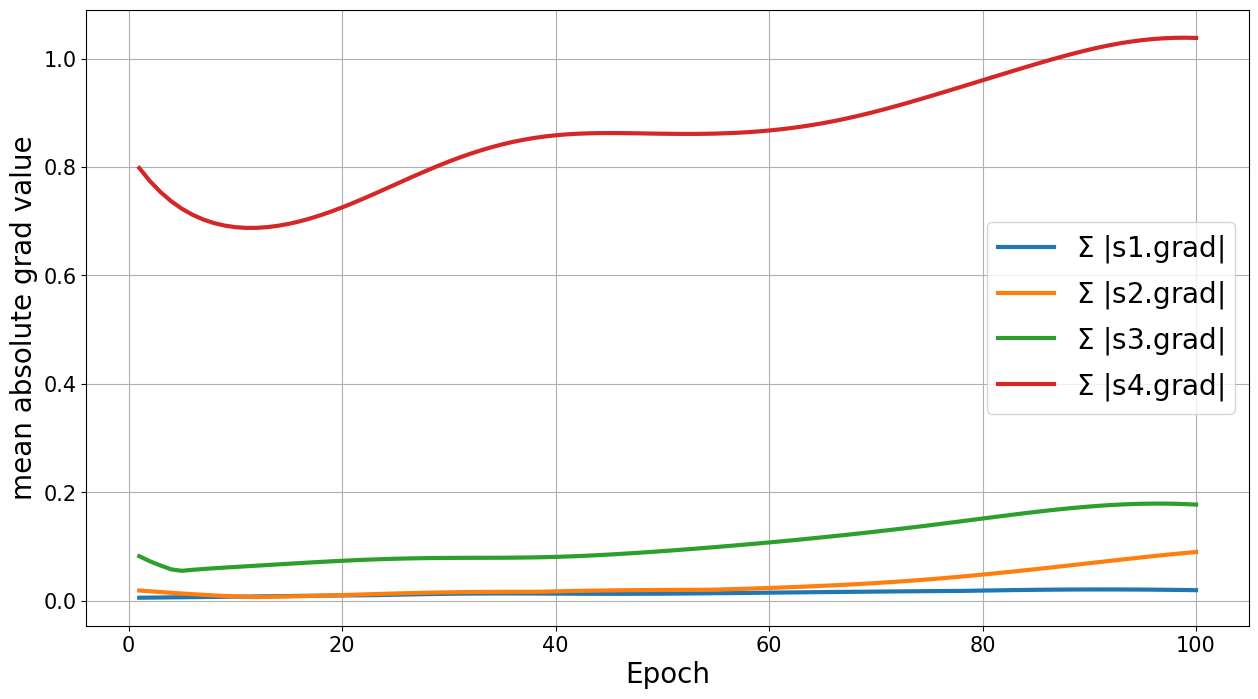

In [12]:
plt.figure(figsize=[15,8])
plt.plot(range(1,EPOCH+1), mean_grad_history_dec[:,0], label = "$\Sigma$ |s1.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history_dec[:,1], label = "$\Sigma$ |s2.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history_dec[:,2], label = "$\Sigma$ |s3.grad|", linewidth=3)
plt.plot(range(1,EPOCH+1), mean_grad_history_dec[:,3], label = "$\Sigma$ |s4.grad|", linewidth=3)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("mean absolute grad value", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

Loss가 s4를 가장 많이 보는 것 확인

In [13]:
# <eos>를 뱉을 때까지, test시의 출력을 다음 입력으로 넣어 확인해본 테스트
# test 로 teacher forcing 말고 하나씩 넣어서 결과 얻기
(x_src, x_trg), y_batch = next(iter(train_DL))
pred = 0 # <sos> 로 시작
model.eval()
for i in range(x_src.shape[0]):
    h_init = torch.zeros(1, x_src.shape[0], hidden_size) # h.shape = (D*num_layer, BS, hidden_size) 를 맞춰줌
    c_init = torch.zeros(1, x_src.shape[0], hidden_size) # 어차피 src.shape[0] == trg.shape[0]
    h = model.enc(x_src[i].unsqueeze(dim=0), h_init,c_init)
    c = c_init
    while idx2word_en[pred] != "<eos>":
        pred_word=torch.tensor(x_one_hot_en[pred]).reshape(1,-1,input_size_en)
        y_hat, (h, c) = model.dec(pred_word, h, c)
        pred = y_hat[i].argmax(dim=1)
        print(idx2word_en[pred], end=" ")

I am an instructor <eos> 